In [1]:
import os
import gzip
import numpy as np
import pandas as pd
from scipy import stats, interpolate
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.api import GLM, families, OLS, graphics
from statsmodels import api as sm
import snapfish2
from snapfish2.utils.simulate import TraceSample
from snapfish2.impute.spatial import *

In [2]:
%reload_ext autoreload
%autoreload 2

1. After randomly rotate each trace, is the covariance the same?
2. Try HeteroPCA/Poisson regression to correct diagonal and transform to pairwise distance
3. Read papers

In [3]:
data_dire = "../../data/takei_nature_2021"
rep_paths = ["4DNFIHF3JCBY.csv", "4DNFIQXONUUH.csv"]
# data_dire = "../../data/jie_aligned_takei_nature_2021"
# rep_paths = ["4DNFIVBL8AWT.csv", "4DNFI7G3BWDF.csv"]
mfrs = []
for i, rep_path in enumerate(rep_paths):
    path = os.path.join(data_dire, rep_path)
    mfrs.append(snapfish2.MulFish(path))
    # Extract FOV ID
    mfrs[-1].data["FOV"] = mfrs[-1].data["Cell_ID"].str.extract(r"(\d+)\_\d+")
    # Add replicate ID to Trace_ID and as a separate column
    mfrs[-1].data["Trace_ID"] = f"{i}_" + mfrs[-1].data["Trace_ID"]
    mfrs[-1].data["Replicate"] = f"rep{i}"
    # Convert voxel coordinates to nm
    mfrs[-1].data["X"] *= 103
    mfrs[-1].data["Y"] *= 103
    mfrs[-1].data["Z"] *= 250
concat_df = pd.concat([m.data for m in mfrs])
mfr = snapfish2.MulFish(concat_df)

In [4]:
chr_id = "chr1"
df, arr = snapfish2.to_very_wide(mfr[chr_id])
d1d = df.index.values
parr = snapfish2.AxisWiseF.preprocess(d1d, arr)
d1d = df.index.values
m1d = (
    mfr[chr_id][["Chrom_Start", "Chrom_End"]]
    .drop_duplicates()
    .sort_values("Chrom_Start")
    .mean(axis=1)
    .values
)

In [5]:
hic_path = "../../data/bonev_2017/contactMatrices/{}_10kb_RAWobserved_matrix.txt.gz"
hic_resol = 10e3
l = int(np.floor(m1d[0]/hic_resol) - 1)
u = int(np.ceil(m1d[-1]/hic_resol) + 2)
hic_mat = pd.read_csv(
    hic_path.format(chr_id), sep=" ", header=None,
    skiprows=lambda x: x < l or x >= u, 
    usecols=np.arange(l, u, dtype="int")
).values
hic1d = np.arange(l, u, dtype="int")*hic_resol + hic_resol/2

(<Figure size 400x400 with 1 Axes>,
 <Axes3D: xlabel='x (nm)', ylabel='y (nm)', zlabel='z (nm)'>)

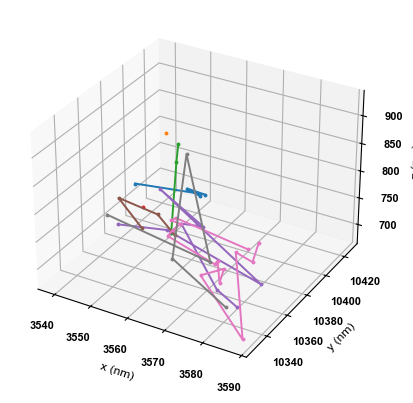

In [6]:
snapfish2.plot.trace(mfr["chr1",210])

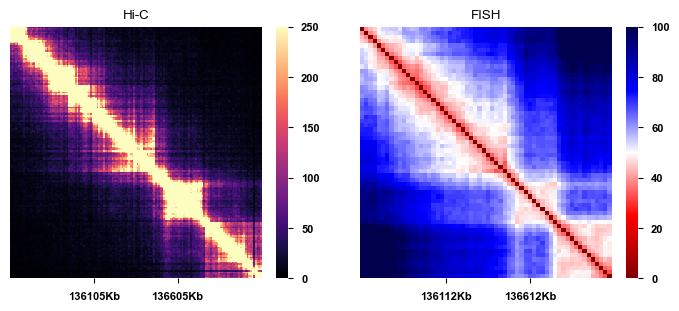

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
snapfish2.plot.pairwise_heatmap(hic_mat, vmax=250, cmap="magma", ax=axes[0], title="Hi-C")
ticks = np.arange(0, hic_mat.shape[0], 50)[1:-1]
axes[0].set(xticks=ticks+0.5, xticklabels=[f"{t/1e3:.0f}Kb" for t in hic1d[ticks]])
d = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
snapfish2.plot.pairwise_heatmap(d, ax=axes[1], vmax=100, title="FISH")
ticks = np.arange(0, d.shape[0], 20)[1:]
axes[1].set(xticks=ticks+0.5, xticklabels=[f"{t/1e3:.0f}Kb" for t in m1d[ticks]])
plt.show()

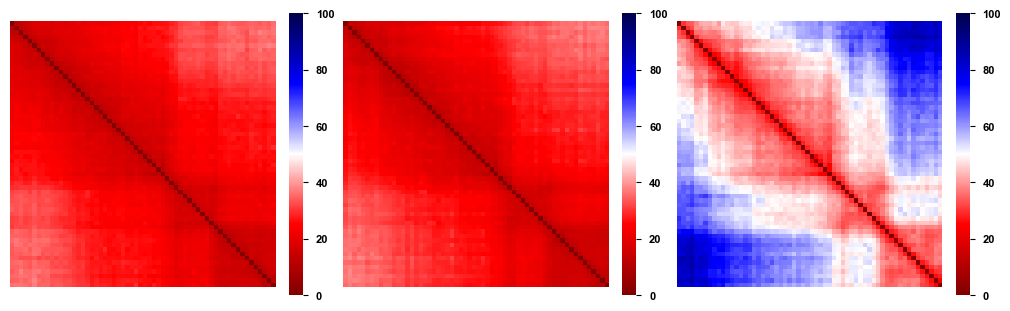

In [8]:
uidx = np.triu_indices(arr.shape[-1])
axis_dist = np.nanmean(np.abs(arr), axis=0)
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, mat in enumerate(axis_dist):
    snapfish2.plot.pairwise_heatmap(mat, ax=axes[i], vmax=100)

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_89091/1335275719.py:12: RuntimeWarning: divide by zero encountered in log
  snapfish2.plot.pairwise_heatmap(-np.log(sym_full_cov), vmax=0, vmin=-10, ax=axes[2], title="-log transformed")


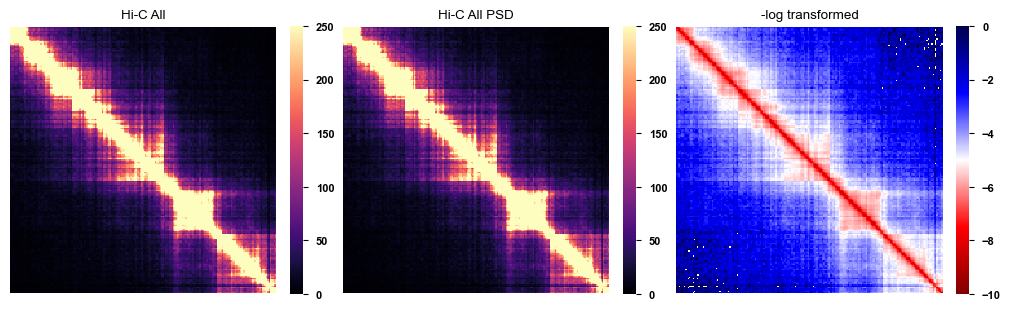

In [9]:
all1d = np.unique(np.concatenate([hic1d, m1d]))
val1d = all1d[:,None] + all1d*1j
rgi = interpolate.RegularGridInterpolator(points=(hic1d, hic1d), values=hic_mat)
full_cov = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)
sym_full_cov = (full_cov + full_cov.T)/2

l, V = np.linalg.eig(sym_full_cov.round(3))
sym_psd = V@np.diag(np.where(l < 0, 0, l))@V.T
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
snapfish2.plot.pairwise_heatmap(sym_full_cov, vmax=250, cmap="magma", ax=axes[0], title="Hi-C All")
snapfish2.plot.pairwise_heatmap(sym_psd, vmax=250, cmap="magma", ax=axes[1], title="Hi-C All PSD")
snapfish2.plot.pairwise_heatmap(-np.log(sym_full_cov), vmax=0, vmin=-10, ax=axes[2], title="-log transformed")

In [12]:
df_ls = []
chr_id = "chr1"
for chr_id in pd.unique(mfr.data.Chrom)[:-1]:
    df, arr = snapfish2.to_very_wide(mfr[chr_id])
    d1d = df.index.values
    parr = snapfish2.AxisWiseF.preprocess(d1d, arr)
    d1d = df.index.values
    m1d = (
        mfr[chr_id][["Chrom_Start", "Chrom_End"]]
        .drop_duplicates()
        .sort_values("Chrom_Start")
        .mean(axis=1)
        .values
    )

    hic_path = "../../data/bonev_2017/contactMatrices/{}_10kb_RAWobserved_matrix.txt.gz"
    hic_resol = 10e3
    l = int(np.floor(m1d[0]/hic_resol) - 1)
    u = int(np.ceil(m1d[-1]/hic_resol) + 2)
    hic_mat = pd.read_csv(
        hic_path.format(chr_id), sep=" ", header=None,
        skiprows=lambda x: x < l or x >= u, 
        usecols=np.arange(l, u, dtype="int")
    ).values
    hic1d = np.arange(l, u, dtype="int")*hic_resol + hic_resol/2

    val1d = m1d[:,None] + m1d*1j
    rgi = interpolate.RegularGridInterpolator(points=(hic1d, hic1d), values=hic_mat)

    full_cov = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)
    sym_full_cov = (full_cov + full_cov.T)/2

    pdist_3d = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
    uidx = np.triu_indices_from(pdist_3d, 1)

    df = pd.DataFrame({"Distance":pdist_3d[uidx], "Count":sym_full_cov[uidx]})
    df["chr"] = chr_id
    df_ls.append(df)
pdist_hic_df = pd.concat(df_ls)

[(0.0, 1.0)]

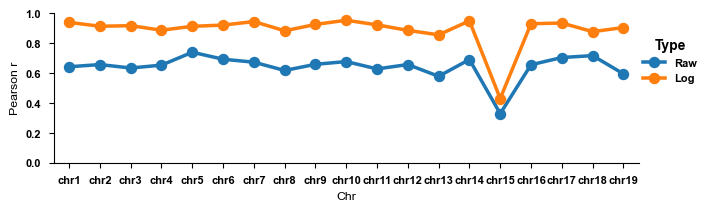

In [35]:
def func(df):
    p1 = stats.pearsonr(df["Distance"].values, df["Count"].values)[0]
    count = np.where(df["Count"].values==0, 1, df["Count"].values)
    p2 = stats.pearsonr(df["Distance"].values, np.log(count))[0]
    return [-p1, -p2]
pearson_df = pdist_hic_df.groupby("chr", sort=False).apply(func, include_groups=False)
df = pd.DataFrame(np.stack(pearson_df.values), columns=["Raw", "Log"], index=pearson_df.index)
df = df.reset_index(names=["Chr"]).melt(id_vars="Chr", var_name="Type", value_name="Pearson r")
fig, ax = plt.subplots(figsize=(7, 2))
sns.pointplot(df, x="Chr", y="Pearson r", hue="Type", ax=ax)
ax.set(ylim=(0, 1))

In [14]:
stats.pearsonr(pdist_3d[uidx], np.log(sym_full_cov[uidx]))[0]

-0.9049623313496284

In [69]:
p = 50
Kh = np.random.uniform(0, 10, (p,p)).round(3)
l, V = np.linalg.eigh((Kh + Kh.T)/2)
lp = np.where(l < 0, 0, l)
print(np.sum(lp > 0))
K = V@np.diag(lp)@V.T
v = K.diagonal()[:,None]
D2 = v@np.ones_like(v).T + np.ones_like(v)@v.T - 2*K
np.linalg.matrix_rank(D2)

25


27

In [10]:
val1d = m1d[:,None] + m1d*1j
a = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)
b = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
idx = np.triu_indices_from(a, 1)
raw_pearsonr = stats.pearsonr(a[idx], b[idx])
log_pearsonr = stats.pearsonr(np.log(a[idx]), b[idx])
raw_pearsonr, log_pearsonr

(PearsonRResult(statistic=-0.6425603120466076, pvalue=1.0519073735103551e-206),
 PearsonRResult(statistic=-0.9396071600083203, pvalue=0.0))

In [52]:
from snapfish2.impute.link import LinkHiCFISH
chr_id = "chr1"
df, arr = snapfish2.to_very_wide(mfr[chr_id])
d1d = df.index.values
parr = snapfish2.AxisWiseF.preprocess(d1d, arr)
d1d = df.index.values
m1d = (
    mfr[chr_id][["Chrom_Start", "Chrom_End"]]
    .drop_duplicates()
    .sort_values("Chrom_Start")
    .mean(axis=1)
    .values
)


k = 5
val1d = m1d[:,None] + m1d*1j
a = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)
# lhf = LinkHiCFISH(arr=arr[:,:,:k,:k], hic_mat=a[:k,:k])
lhf = LinkHiCFISH(arr=arr, hic_mat=a)
lhf.fit_ols_rev()

array([ 681.28028844,  690.16310203, 1737.26419459,  -57.0368567 ])

In [36]:
np.sqrt(1737.2642)

41.68050143652305

AttributeError: 'GLMResults' object has no attribute 'mse_resid'

<Figure size 640x440 with 0 Axes>

In [200]:
np.square(np.nanmean(np.abs(arr), axis=0))*np.pi/2

array([[[    0.        ,   229.39476317,   285.10278614, ...,
          1913.29029071,  1826.81670327,  2000.22345333],
        [  229.39476317,     0.        ,   273.16057684, ...,
          1981.21525482,  1877.58702877,  2078.81822242],
        [  285.10278614,   273.16057684,     0.        , ...,
          2106.80174695,  1997.26150837,  2095.9526185 ],
        ...,
        [ 1913.29029071,  1981.21525482,  2106.80174695, ...,
             0.        ,   215.40665051,   247.97528288],
        [ 1826.81670327,  1877.58702877,  1997.26150837, ...,
           215.40665051,     0.        ,   236.432106  ],
        [ 2000.22345333,  2078.81822242,  2095.9526185 , ...,
           247.97528288,   236.432106  ,     0.        ]],

       [[    0.        ,   274.67777934,   293.03985512, ...,
          2145.12978828,  2080.6062328 ,  1982.66015519],
        [  274.67777934,     0.        ,   223.65843255, ...,
          2266.20723174,  2225.33896779,  2130.6424069 ],
        [  293.03985512, 

In [198]:
lhf.loglklhd(beta=-10, tau_sq=np.square([50, 50, 70]))

/Users/redfishhh/Documents/research/MultiplexedFISH/library/snapfish2/impute/link.py:31: RuntimeWarning: invalid value encountered in sqrt
  p1 = np.concatenate([[p1_beta], p1_taui])


nan

In [196]:
lhf._update()
lhf.params

[           nan            nan            nan 1.59819532e+20]


array([nan, nan, nan, nan])

In [148]:
uidx = np.triu_indices(arr.shape[-1], 1)
X0 = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)[uidx]
X = np.stack([np.ones_like(X0), X0]).T
Y = hic_mat[uidx]
GLM(exog=X, endog=Y, family=families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1770
Model:                            GLM   Df Residuals:                     1768
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53183.
Date:                Tue, 03 Dec 2024   Deviance:                       94869.
Time:                        13:35:05   Pearson chi2:                 1.04e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4962      0.007   1343.790      0.000       9.482       9.510
x1            -0.0720      0.000   -530.885      0.000      -0.072      -0.072
==============================================================================
"""

<Axes: >

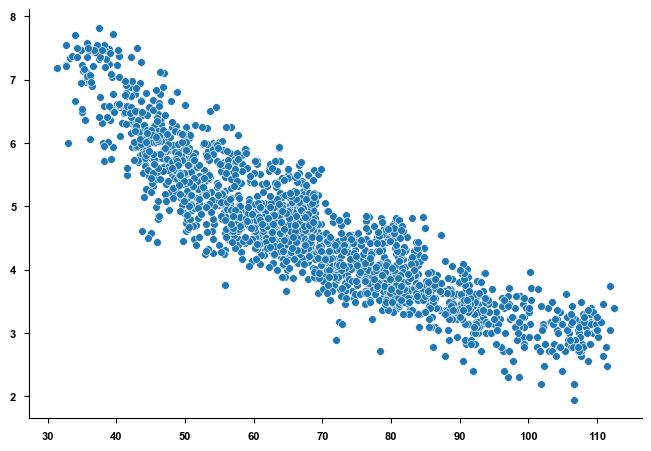

In [149]:
sns.scatterplot(x=X0, y=np.log(Y))

In [43]:
for i in range(arr.shape[1]):
    X = np.nanmean(np.abs(arr[:,i,:,:]), axis=0)[idx]
    X = np.stack([np.ones_like(X), X]).T
    val1d = m1d[:,None] + m1d*1j
    y = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)[idx]
    result = GLM(exog=X, endog=y, family=families.Poisson()).fit()
    print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5134      0.012    787.306      0.000       9.490       9.537
x1            -0.2618      0.001   -374.238      0.000      -0.263      -0.260
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1630      0.011    806.276      0.000       9.141       9.185
x1            -0.2445      0.001   -367.963      0.000      -0.246      -0.243
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5070      0.012    776.533      0.000       9.483       9.531
x1            -0.1249      0.000   -368.253      0.000      -0.126      -0.124


In [72]:
val1d = m1d[:,None] + m1d*1j
X = np.log(rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)[idx])
X = np.stack([np.ones_like(X), X]).T
for i in range(arr.shape[1]):
    y = np.nanmean(np.abs(arr[:,i,:,:]), axis=0)[idx]
    result = OLS(exog=X, endog=y).fit()
    print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5681      0.140    268.219      0.000      37.293      37.843
x1            -4.1068      0.038   -107.814      0.000      -4.182      -4.032
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.8874      0.145    269.023      0.000      38.604      39.171
x1            -4.4161      0.039   -112.338      0.000      -4.493      -4.339
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.2431      0.344    239.214      0.000      81.569      82.917
x1            -9.4286      0.094   -100.840      0.000      -9.612      -9.245


In [158]:
axis_pdist = np.nanmedian(np.square(arr[:,:,:,:]), axis=0)[1]
# l, V = np.linalg.eigh(axis_pdist)
# d = V@np.diag(np.where(l > 0, 0, l))@V.T
d = axis_pdist
print(d.max())
vs = np.random.uniform(3000, 10000, (d.shape[0], 1000))
def func(v):
    v = v[:,None]
    K = v@np.ones_like(v).T + np.ones_like(v)@v.T - d
    eigv = np.linalg.eigh(K)[0].round(10)
    return np.sum(eigv < 0)
np.apply_along_axis(func, axis=0, arr=vs)

1113.6903839997165


array([21, 21, 21, 20, 21, 20, 21, 21, 20, 20, 21, 21, 21, 20, 20, 20, 21,
       21, 21, 21, 21, 21, 20, 21, 21, 20, 21, 21, 21, 21, 21, 20, 20, 20,
       21, 21, 21, 21, 21, 21, 20, 21, 21, 20, 21, 20, 21, 21, 21, 21, 21,
       21, 21, 21, 20, 20, 20, 21, 21, 20, 20, 21, 20, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 20, 21, 20, 20, 21, 20, 21, 20, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 20, 21, 20, 20, 21, 20, 21, 21, 20, 21, 20, 20,
       20, 20, 20, 21, 21, 21, 20, 21, 21, 21, 20, 21, 21, 21, 21, 21, 20,
       21, 21, 21, 21, 20, 21, 21, 20, 21, 21, 21, 20, 21, 20, 20, 20, 20,
       21, 21, 21, 20, 21, 21, 20, 21, 20, 21, 20, 21, 20, 21, 21, 20, 21,
       21, 21, 20, 21, 21, 20, 20, 20, 21, 20, 20, 21, 20, 21, 21, 20, 21,
       20, 21, 21, 21, 21, 21, 21, 20, 21, 20, 21, 20, 20, 21, 20, 21, 20,
       21, 21, 20, 20, 21, 21, 21, 21, 21, 20, 20, 21, 21, 20, 21, 21, 20,
       20, 21, 21, 20, 20, 20, 20, 20, 21, 20, 20, 21, 21, 21, 21, 21, 20,
       20, 21, 21, 21, 21

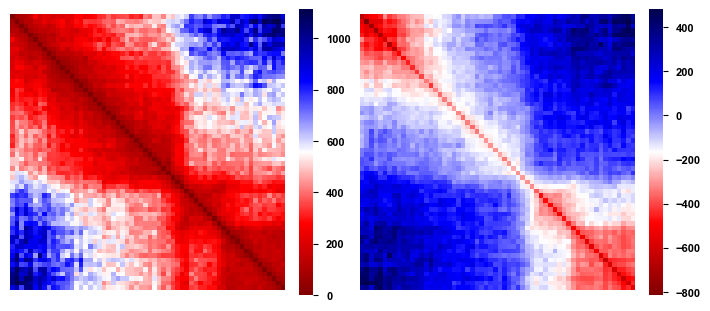

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
snapfish2.plot.pairwise_heatmap(axis_pdist, ax=axes[0])
snapfish2.plot.pairwise_heatmap(d, ax=axes[1])

<Axes: ylabel='Count'>

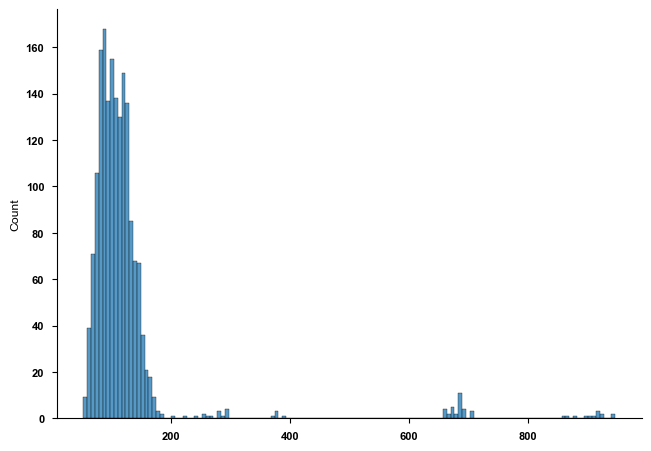

In [151]:
max_ent = np.nanmax(arr[:,0,:,:], axis=0)
sns.histplot(max_ent[np.triu_indices_from(max_ent, 1)])

In [73]:
np.linalg.eig(np.nanmean(np.square(arr[:,:,:,:]), axis=0)[0])

EigResult(eigenvalues=array([ 6.12647417e+04, -2.49761039e+04, -8.48070033e+03, -6.88338136e+03,
        5.07256685e+03,  3.83868175e+03, -4.52520978e+03, -2.65753594e+03,
       -1.80387428e+03, -1.51214601e+03,  6.61447067e+02, -1.37038623e+03,
        4.29676953e+02, -1.21422386e+03, -1.16787251e+03, -1.04087020e+03,
        2.42433783e+02, -9.31532697e+02, -9.24633616e+02, -8.97246026e+02,
        1.67250269e+02, -8.36291426e+02,  7.72313218e+01, -7.37755575e+02,
       -7.06717223e+02, -6.67593903e+02,  2.33971599e+01, -6.46512275e+02,
       -4.25858108e+00, -2.88732824e+01, -6.12065536e+02, -5.98788881e+02,
       -6.23782146e+01, -5.57224388e+02, -5.32934075e+02, -5.16999972e+02,
       -8.78355506e+01, -4.76289004e+02, -1.19428394e+02, -1.32167419e+02,
       -1.36013251e+02, -4.51202311e+02, -4.30520615e+02, -4.18762167e+02,
       -4.17302701e+02, -4.03661194e+02, -3.95318717e+02, -1.69606413e+02,
       -1.87275783e+02, -3.56909337e+02, -3.41192187e+02, -2.11251025e+02,
   

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_32211/7729243.py:4: RuntimeWarning: invalid value encountered in sqrt
  snapfish2.plot.pairwise_heatmap(est_d**.5, vmin=50, vmax=150)


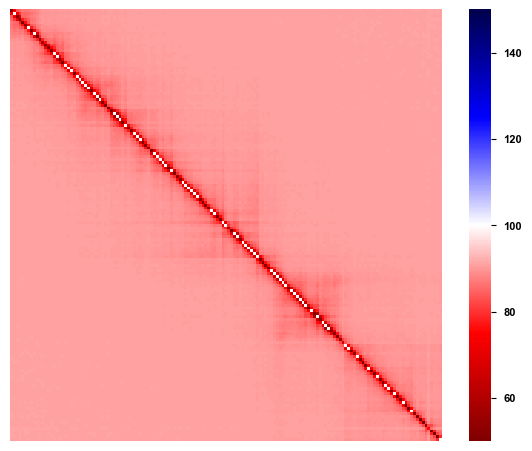

In [195]:
v = np.diag(hic_mat)[:,None]
v = np.ones_like(v)*np.mean(v)
est_d = np.ones_like(v)@v.T + v@np.ones_like(v).T - 2*hic_mat
snapfish2.plot.pairwise_heatmap(est_d**.5, vmin=50, vmax=150)

In [25]:
val1d = m1d[:,None] + m1d*1j
X = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T)
idx = np.triu_indices_from(val1d, 1)
# X = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
X = np.tile(X.reshape(val1d.shape)[idx], arr.shape[1])
dummy = np.zeros((arr.shape[1], len(X)))
for i in range(arr.shape[1]):
    dummy[i,i*len(idx[0]):(i+1)*len(idx[0])] = 1
X = np.vstack([dummy, np.log(X)**2]).T

y = np.concatenate(np.nanmean(np.square(arr[:,:,:,:]), axis=0)[:,*idx])

res = OLS(exog=X, endog=y).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     1388.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:17:36   Log-Likelihood:                -49317.
No. Observations:                5310   AIC:                         9.864e+04
Df Residuals:                    5306   BIC:                         9.867e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6257.2072     78.645     79.563      0.000    6103.031    6411.384
x2          6122.6816     78.645     77.852      0.000    5968.505    6276.858
x3          7700.2539     78.645     97.912      0.000    7546.077    7854.430
x4          -218.8053      3.564    -61.389      0.000    -225.793    -211.818
==============================================================================
Omnibus:                     2457.265   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15158.525
Skew:                           2.147   Prob(JB):                         0.00
Kurtosis:                      10.076   Cond. No.                         48.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
np.sqrt(res.params[:-1]/2)

array([32.71289527, 33.09827593, 52.60856516])

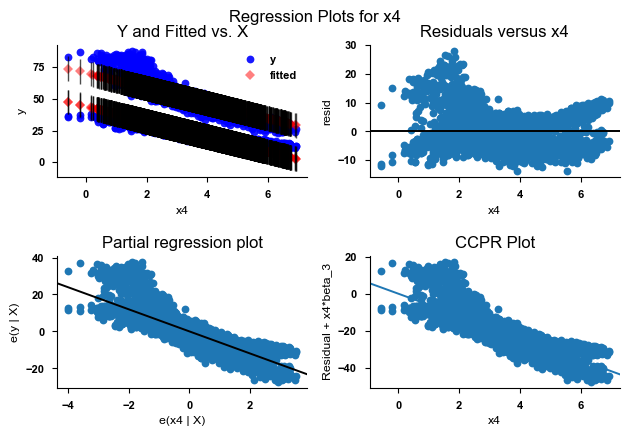

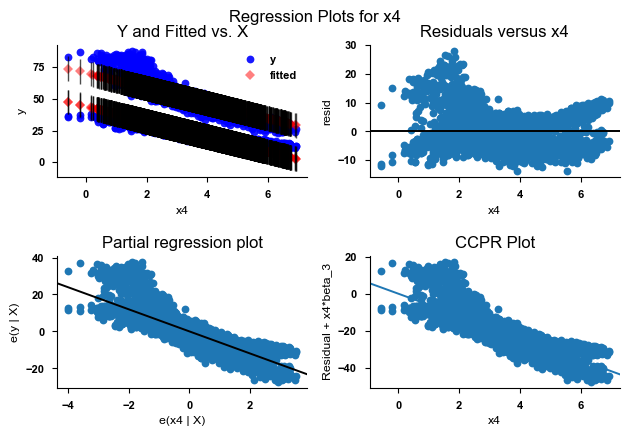

In [91]:
graphics.plot_regress_exog(res, 3)

In [170]:
val1d = m1d[:,None] + m1d*1j
X = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T)
idx = np.triu_indices_from(val1d, 1)
# X = np.nanmean(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
X = np.tile(X.reshape(val1d.shape)[idx], arr.shape[1])
dummy = np.zeros((arr.shape[1], len(X)))
for i in range(arr.shape[1]):
    dummy[i,i*len(idx[0]):(i+1)*len(idx[0])] = 1
X = np.vstack([dummy, np.log(X)]).T

y = np.concatenate(np.nanmean(np.abs(arr[:,:,:,:]), axis=0)[:,*idx])

res = OLS(exog=X, endog=y).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 1.624e+04
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:40:23   Log-Likelihood:                -15992.
No. Observations:                5310   AIC:                         3.199e+04
Df Residuals:                    5306   BIC:                         3.202e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            43.9726      0.205    214.819      0.000      43.571      44.374
x2            44.2364      0.205    216.108      0.000      43.835      44.638
x3            70.4896      0.205    344.363      0.000      70.088      70.891
x4            -5.9838      0.049   -121.514      0.000      -6.080      -5.887
==============================================================================
Omnibus:                     1193.086   Durbin-Watson:                   0.424
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3639.185
Skew:                           1.150   Prob(JB):                         0.00
Kurtosis:                       6.340   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[       0.,    -7500.,   -10000., ..., -1482500., -1490000.,
        -1500000.],
       [    7500.,        0.,    -2500., ..., -1475000., -1482500.,
        -1492500.],
       [   10000.,     2500.,        0., ..., -1472500., -1480000.,
        -1490000.],
       ...,
       [ 1482500.,  1475000.,  1472500., ...,        0.,    -7500.,
          -17500.],
       [ 1490000.,  1482500.,  1480000., ...,     7500.,        0.,
          -10000.],
       [ 1500000.,  1492500.,  1490000., ...,    17500.,    10000.,
               0.]])

In [279]:
all1d = np.unique(np.concatenate([hic1d, m1d]))
val1d = all1d[:,None] + all1d*1j
rgi = interpolate.RegularGridInterpolator(points=(hic1d, hic1d), values=hic_mat)
full_hic = rgi(np.stack([val1d.imag.flat, val1d.real.flat]).T).reshape(val1d.shape)
sym_full_hic = (full_hic + full_hic.T)/2
idx = np.triu_indices_from(sym_full_hic, 1)
# mat_1d = np.abs(all1d[:,None] - all1d[None,:])
# sns.scatterplot(x=mat_1d[idx], y=sym_full_hic[idx])
np.fill_diagonal(sym_full_hic, np.mean(np.diag(sym_full_hic)))

trf_hic = stats.boxcox(sym_full_hic, 0)
trf_hic = sym_full_hic
h = np.diag(trf_hic)[:,None]
K = h@np.ones_like(h).T + np.ones_like(h)@h.T - 2*trf_hic
kidx = np.where(np.isin(all1d, m1d))[0]
sub_K = K[kidx][:,kidx]

uidx = np.triu_indices_from(sub_K, 1)
X = np.tile(sub_K[uidx], arr.shape[1])
dummy = np.zeros((arr.shape[1], len(X)))
for i in range(arr.shape[1]):
    dummy[i,i*len(uidx[0]):(i+1)*len(uidx[0])] = 2
X = np.vstack([dummy, X]).T

y = np.concatenate(np.nanmedian(np.square(arr[:,:,:,:]), axis=0)[:,*uidx])

res = OLS(exog=X, endog=y).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     2273.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:43:39   Log-Likelihood:                -42130.
No. Observations:                5310   AIC:                         8.427e+04
Df Residuals:                    5306   BIC:                         8.429e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4057.9591    131.785    -30.792      0.000   -4316.311   -3799.607
x2         -4050.8262    131.785    -30.738      0.000   -4309.178   -3792.474
x3         -3307.3414    131.785    -25.097      0.000   -3565.694   -3048.989
x4             1.1246      0.035     32.351      0.000       1.056       1.193
==============================================================================
Omnibus:                     2567.610   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19616.492
Skew:                           2.177   Prob(JB):                         0.00
Kurtosis:                      11.349   Cond. No.                     1.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [285]:
l, V = np.linalg.eigh(sym_full_cov)
np.diag(V@np.where(l <= 0, 0.001, l)@V.T)

array([[ 6232.92991704,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  -385.46946655,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        , -8160.82753461, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        -2354.26021783,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  5019.25117307,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3938.41483028]])

In [180]:
rlm_model = sm.RLM(exog=X, endog=y, M=sm.robust.norms.HuberT(2))
rlm_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 5310
Model:                            RLM   Df Residuals:                     5306
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 25 Nov 2024                                         
Time:                        16:42:46                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.6448      0.173    247.182      0.000      42.307      42.983
x2            42.9123      0.173    248.732      0.000      42.574      43.250
x3            68.0241      0.173    394.288      0.000      67.686      68.362
x4            -5.5958      0.042   -134.823      0.000      -5.677      -5.514
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""